<a id='top'></a>
Let's take a peek into the structure of Dr. Terhonen's data, using a cooccurrence network approach. 

[Python and R setup](#pyset)  
[Data prep](#dataClean)  
[Define cooccurrences](#cooccur)  
[High-disease and low-disease associated fungal OTUS](#cooccurOTUs)  
[Network diagnostics](#stats) 
- [degree distributions](#dd)
- [modularity](#mod)
- [mean clustering coefficient](#mcc)
- [betweenness centrality](#bc)
- [closeness centrality](#cc)
- [nestedness](#wnodf)
- [indicator species](#ind)  

<a id="pyset"></a>
### Python setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import networkx, random
from networkx.algorithms import community
import openpyxl
from bokeh.models import MultiLine, Circle, Plot
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, from_networkx
from matplotlib_venn import venn2, venn3

output_notebook()

Loading BokehJS ...

### R setup

In [7]:
library("cooccur")
library("MBI")
library("indicspecies")
library("vegan")
library("repr")

[back to top](#top)

<a id="dataClean)"></a>
### Data prep

Dr. Terhonen has supplied an OTU table. It's big, too big for a spreadsheet gui, really. So get it into memory, and work with it as a pandas df.

In [18]:
## it's big. get it into memory, save it as csv and work with it as a pandas df
wb = openpyxl.load_workbook('Real_Abundance.xlsx')
wb.sheetnames
raw = wb['Sheet1']
eevaOTU = pd.DataFrame(raw.values)
eevaOTU.columns = eevaOTU.iloc[0]
eevaOTU = eevaOTU.drop([0]).reset_index(drop=True)
#eevaOTU.to_csv('eevaOTU.csv')
eevaOTU.iloc[0:3,0:10]

,SampleID,Samplingtime,Growthyear,Diseaseclass,OTU4,OTU428,OTU258,OTU524,OTU491,OTU878
0,10B,June,Year_2018,1,961.413,0,7.55234,0,0,0
1,11B,June,Year_2018,2,579.291,0.699626,9.79477,0,2.09888,0
2,11C,June,Year_2017,2,2152.46,0,16.6534,0,1.38779,0


In [19]:
eevaOTU.shape

(95, 1270)

We are going to do a very simplistic low-disease/high-disease set of comparisons. For the moment we'll drop the other predictors.

In [20]:
lowDisease = eevaOTU['Diseaseclass'].isin([0,1,2]).replace({True:1, False:0})
highDisease = eevaOTU['Diseaseclass'].isin([3,4,5]).replace({True:1, False:0})

eevaOTU.insert(4,"lowDisease",lowDisease)
eevaOTU.insert(5,"highDisease",highDisease)
lowHiDiseaseTable = eevaOTU.drop(columns=['SampleID','Samplingtime','Growthyear','Diseaseclass'])

In [21]:
eevaOTU.iloc[0:3,0:10]

,SampleID,Samplingtime,Growthyear,Diseaseclass,lowDisease,highDisease,OTU4,OTU428,OTU258,OTU524
0,10B,June,Year_2018,1,1,0,961.413,0,7.55234,0
1,11B,June,Year_2018,2,1,0,579.291,0.699626,9.79477,0
2,11C,June,Year_2017,2,1,0,2152.46,0,16.6534,0


I see some funky values in there. Let's make sure that all cells in this are numeric:

In [23]:
for name,i in lowHiDiseaseTable.iterrows():
    bb = i.apply(lambda x: isinstance(x, str))
    if not (i[bb]).empty:
        print(i[bb])
        print(name)


0
OTU4    15722,4745237,614
Name: 4, dtype: object
4


row 4 of OTU4 has three values in it. We are about to convert to presence/absence, so let's just replace with 1. 

In [24]:
lowHiDiseaseTable.loc[4,'OTU4'] = 1

lowHiDiseaseTablePA = (lowHiDiseaseTable > 0).astype(int)

In [29]:
lowHiDiseaseTablePA.iloc[0:5,0:10]

,lowDisease,highDisease,OTU4,OTU428,OTU258,OTU524,OTU491,OTU878,OTU915,OTU954
0,1,0,1,0,1,0,0,0,0,0
1,1,0,1,1,1,0,1,0,0,0
2,1,0,1,0,1,0,1,0,0,0
3,1,0,1,0,1,0,0,0,0,0
4,1,0,1,1,1,0,1,1,0,0


In [ ]:
#lowHiDiseaseTablePA.to_csv('lowHiDiseaseTablePA.csv')

[back to top](#top)

<a id="cooccur"></a>
### Define cooccurrences

We'll use a probabilistic approach, proposed by [Veech et al. (2013)](#https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1466-8238.2012.00789.x), using the R package, [cooccur](#https://www.jstatsoft.org/article/view/v069c02). We'll construct three networks: low-disease samples, high-disease samples, and all (combined) samples. But to reduce clutter, I'll just show the pipeline for one network, from P/A otu table (created above) to adjacency matrix, which is the object which most network analysis software starts from. 

Running the cooccurrence checks on the networks takes several hours on my poor old laptop, so don't recommend running it here unless necessary. Just putting the steps here for posterity. The R data objects that result are saved in the github repo.

In [31]:
## prep low-disease and high-disease matrices with pandas (python)

### low-disease community matrix
lowMask = (lowHiDiseaseTablePA['lowDisease'] == 1)
lowDiseaseTablePA = lowHiDiseaseTablePA[lowMask].drop(columns=['lowDisease', 'highDisease'])
## any lost taxa?
(lowDiseaseTablePA.sum(axis=0) == 0).any() ## yes, some taxa are lost

lostTaxa = (lowDiseaseTablePA.sum(axis=0) == 0)
notLostTaxa = ~(lostTaxa)
lowDiseaseTablePA.loc[:,lostTaxa].shape
lowDiseaseTablePA.loc[:,notLostTaxa].shape
## any all zero sites?
(lowDiseaseTablePA.sum(axis=1) == 0).any() ## nope
## save:
#lowDiseaseTablePA.to_csv('lowDiseaseTablePA.csv')

True

In R kernel, not run here because it takes so long:

In [ ]:
## make low-disease network:

library('cooccur')

## I think we need OTUs as rows, sites as columns, so transpose:
lowDiseaseTablePA <- t(read.csv('lowDiseaseTablePA.csv',
                        header=TRUE, row.names=1))

cooccur.sph.low <- cooccur(mat=lowDiseaseTablePA,
                          type="spp_site",
                          thresh=TRUE,
                          spp_names=TRUE)
save(cooccur.sph.low, file='cooccur.sph.low.rda')


Okay, so we have three sets of cooccurrence results objects. 

We can check these for OTUs that are particularly associated with one disease state or the other. And we can use these to make adjacency matrices for our three networks. First we adjust our p-values for the numerous multiple comparisons involved in networks, in R:

In [7]:
load('cooccur.sph.low.rda')
cooccur.sph.low.results <- cooccur.sph.low$results
## apply bejamini-hochburg to positive cooccurrence p-values
p_gt_adj <- p.adjust(cooccur.sph.low.results$p_gt, method = "BH")
cooccur.sph.low.results$p_gt_adj <- p_gt_adj
## let's keep an FDR of .05 or less:
posMask <- cooccur.sph.low.results$p_gt_adj <= 0.05
cooccur.sph.low.pos <- cooccur.sph.low.results[posMask,]
rownames(cooccur.sph.low.pos) <- NULL
#write.csv(cooccur.sph.low.pos, file="cooccur_sph_low_pos.csv", row.names=FALSE)
head(cooccur.sph.low.pos)

,sp1,sp2,sp1_inc,sp2_inc,obs_cooccur,prob_cooccur,exp_cooccur,p_lt,p_gt,sp1_name,sp2_name,p_gt_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
1,4,5,16,20,13,0.123,6.3,1.00000,0.00005,OTU524,OTU491,0.01161071
2,11,77,23,35,22,0.309,15.8,1.00000,0.00012,OTU327,OTU218,0.01778587
3,14,738,27,16,14,0.166,8.5,0.99994,0.00083,OTU194,OTU434,0.04459888
4,15,122,7,11,6,0.030,1.5,1.00000,0.00016,OTU789,OTU757,0.02034141
5,18,107,43,37,36,0.612,31.2,1.00000,0.00020,OTU111,OTU246,0.02323523
6,18,326,43,42,40,0.694,35.4,1.00000,0.00012,OTU111,OTU234,0.01778587


Then we go back to pandas in python to code our adjacency matrix, because I love it more than R.

In [9]:
lowPosCooc = pd.read_csv("cooccur_sph_low_pos.csv")
otus = (lowPosCooc.loc[:,'sp1_name'].
        append(lowPosCooc.loc[:,'sp2_name']).
        unique())
matches = lowPosCooc.loc[:,['sp1_name','sp2_name']]
aa = np.zeros(shape = (len(otus),len(otus)), dtype='int')
lowPosAdjacency = pd.DataFrame(data=aa, index = otus, columns = otus)
for _,i in matches.iterrows():
    lowPosAdjacency.loc[i.sp1_name,i.sp2_name] = 1

#lowPosAdjacency.to_csv('lowPosAdjacency.csv')

This gives us our adjacency matrices. They are sparse:

In [8]:
lowPosAdjacency.iloc[1:15,1:15]

,OTU327,OTU194,OTU789,OTU111,OTU279,OTU680,OTU467,OTU152,OTU373,OTU553,OTU264,OTU472,OTU247,OTU421
OTU327,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OTU194,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OTU789,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OTU111,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OTU279,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OTU680,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OTU467,0,0,0,0,0,0,0,0,0,0,0,0,1,0
OTU152,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OTU373,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OTU553,0,0,0,0,0,0,0,0,0,0,0,0,0,0


[back to top](#top)

<a id="cooccurOTUs"></a>
#### High-disease and low-disease associated fungal OTUS

Before we move on, we can check these for OTUs that are associated with the plants that show few or no disease symptoms (disease classes 0-2), and those that tend to associate with plants showing more disease symptoms (disease classes 3-5). This is the main reason we ran a cooccurrence analysis on the entire set of samples.

In [14]:
### low-disease-associated OTUs:
cooccur_combo_pos = pd.read_csv("cooccur_sph_combo_pos.csv")
lowDiseaseAssociateMask = cooccur_combo_pos['sp1_name'] == 'lowDisease'
lowDisAssociates = cooccur_combo_pos[lowDiseaseAssociateMask].sp2_name

print(lowDisAssociates)

0    OTU194
1    OTU726
2    OTU993
Name: sp2_name, dtype: object


According to Dr. Terhonen's notes:  
- OTU194  is an unidentified ascomycete.  
- OTU726  this is an unidentified fungus, not even to phyla.  
- OTU993 is an unidentified ascomycete  

In [15]:
#### high-disease-associated OTUs:
cooccur_combo_pos = pd.read_csv("cooccur_sph_combo_pos.csv")
highDiseaseAssociateMask = cooccur_combo_pos['sp1_name'] == 'highDisease'
highDisAssociates = cooccur_combo_pos[highDiseaseAssociateMask].sp2_name

print(highDisAssociates)

3    OTU709
4    OTU343
Name: sp2_name, dtype: object


According to Dr. Terhonen's notes, the closest match for OTU709 is *Phaeosphaeria* sp., So another pathogen, most likely.  
OTU343 is identified only to the kingdom level, as a fungus. 

[back to top](#top)

<a id=stats></a>
### Network diagnostics

From here we can use [Networkx](https://networkx.org/) to do most of the heavy lifting:

In [27]:
highPosAdjacency = pd.read_csv('highPosAdjacency.csv', index_col=0)
lowPosAdjacency = pd.read_csv('lowPosAdjacency.csv', index_col=0)

lowAdj = networkx.from_pandas_adjacency(lowPosAdjacency)
highAdj = networkx.from_pandas_adjacency(highPosAdjacency)
print("low-disease network info:")
print(networkx.info(lowAdj))
print("-------------------------")
print("high-disease network info:")
print(networkx.info(highAdj))

low-disease network info:
Name: 
Type: Graph
Number of nodes: 772
Number of edges: 11441
Average degree:  29.6399
-------------------------
high-disease network info:
Name: 
Type: Graph
Number of nodes: 688
Number of edges: 7547
Average degree:  21.9390


<a id="dd"></a>
##### degree distributions

Text(0.5, 0.98, 'degree distributions')

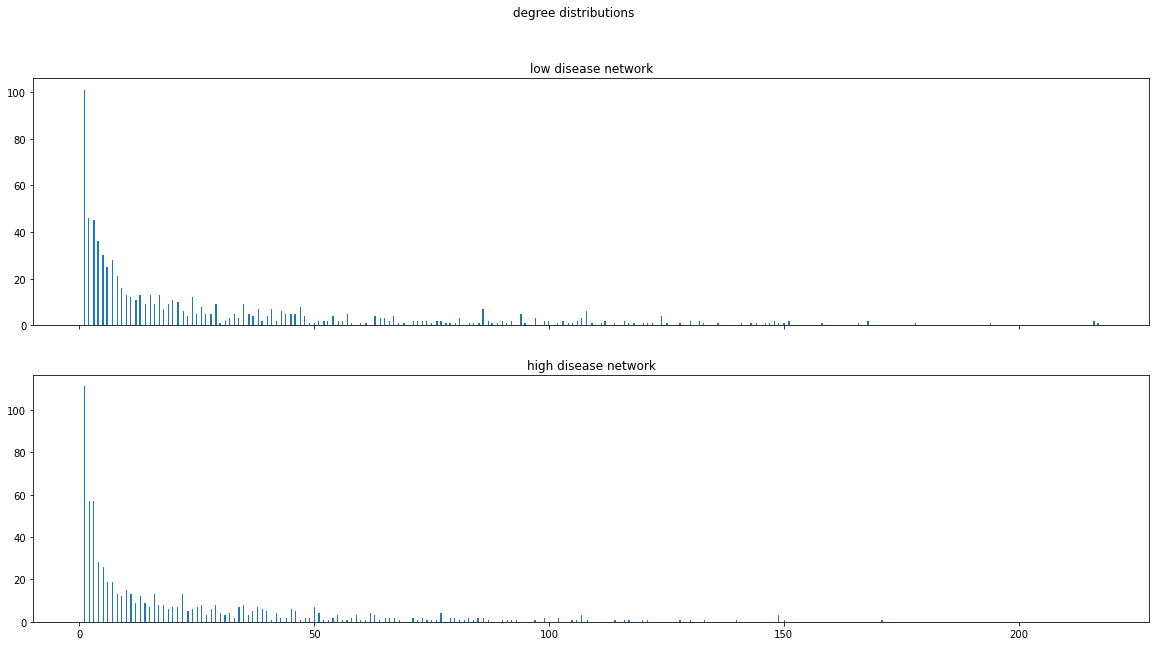

In [31]:
fig, ax = plt.subplots(2, sharex=True, figsize=(20,10))
lowAdjdegreez = [ i[1] for i in lowAdj.degree ]
ax[0].hist(lowAdjdegreez, log=False, bins=len(lowAdjdegreez))
ax[0].set_title('low disease network')
highAdjdegreez = [ i[1] for i in highAdj.degree ]
ax[1].hist(highAdjdegreez, log=False, bins=len(highAdjdegreez))
ax[1].set_title('high disease network')
fig.suptitle('degree distributions')


The general distributions don't look that different, both are classic power-law-ish things, or something like it. And shared species among the samples are high, not a lot of OTUs are lost when we go from low-disease to high-disease samples. Each set (low-disease vs. high-disease observed OTUs) has a dozen or so OTUs that are unique, not observed in the other set, most OTUs are represented in both:

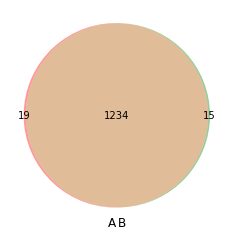

In [40]:
## low
lowHiDiseaseTablePA = pd.read_csv('lowHiDiseaseTablePA.csv', index_col=0)
aa = lowHiDiseaseTablePA[lowHiDiseaseTablePA['lowDisease'] == 1]
lowDiseaseAllColumns = aa.loc[:,~(aa.sum(axis=0) == 0)].columns
## high
lowHiDiseaseTablePA = pd.read_csv('lowHiDiseaseTablePA.csv', index_col=0)
aa = lowHiDiseaseTablePA[lowHiDiseaseTablePA['highDisease'] == 1]
highDiseaseAllColumns = aa.loc[:,~(aa.sum(axis=0) == 0)].columns

venn2([
    set(highDiseaseAllColumns),
    set(lowDiseaseAllColumns)
])


But if we look at "hub" species, or species that have the most links to other other species, we see some architectural differences in the networks. Different species are becoming important with onset of disease symptoms. We can find the top 200 OTUs in each network with the highest degree, and check for shifts:

Text(0.5, 1.0, 'Shared hub-nodes')

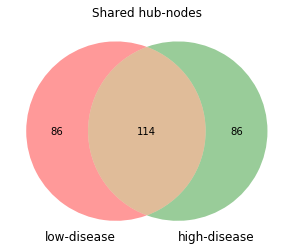

In [48]:
## low-disease hub nodes
aa = list(lowAdj.degree)
bb = list(zip(*aa))
cc = pd.Series(bb[1], index=bb[0])
cc[cc == cc.max()]
lowAdjDeg = cc.sort_values(ascending=False)
## rinse and repeat for high-disease hub nodes 
aa = list(highAdj.degree)
bb = list(zip(*aa))
cc = pd.Series(bb[1], index=bb[0])
cc[cc == cc.max()]
highAdjDeg = cc.sort_values(ascending=False)
fig, ax = plt.subplots()
venn2([
    set(lowAdjDeg[0:200].index),
    set(highAdjDeg[0:200].index)
      ],
    set_labels=("low-disease","high-disease"),
    ax=ax
)
ax.set_title('Shared hub-nodes')

So while the overall shapes and size of the network are constant, the importance of individual OTUs appears to be shifting.

[back to top](#top)

<a id='mod'></a>
##### modularitly

We'll try the "Clauset-Newman-Moore greedy modularity maximization" to delineate modules/communities in our networks, then use these to measure the modularity of the network:

In [2]:
lowPosAdjacency = pd.read_csv('lowPosAdjacency.csv', index_col=0)
lowAdj = networkx.from_pandas_adjacency(lowPosAdjacency)
highPosAdjacency = pd.read_csv('highPosAdjacency.csv', index_col=0)
highAdj = networkx.from_pandas_adjacency(highPosAdjacency)

In [3]:
lowAdj_communities_generator = community.greedy_modularity_communities(lowAdj)
lowAdj_communities = list(lowAdj_communities_generator)

highAdj_communities_generator = community.greedy_modularity_communities(highAdj)
highAdj_communities = list(highAdj_communities_generator)

In [6]:
print ("low-disease modularity = " + str(community.modularity(lowAdj, lowAdj_communities)))
print ("high-disease modularity = " + str(community.modularity(highAdj, highAdj_communities)))

low-disease modularity = 0.22091213437583188
high-disease modularity = 0.24858977026069504


So again, the network maintains a similar level of modularity, meaning that it is forming communities within the broader network that are at least somewhat more connected inwardly than externally (need to conduct some significance tests to say this with real confidence). But the communities appear to be different between the low and high disease states. 

The lower-disease state seems to organize into three large modules, whereas the higher host disease state seems to have broken this up a bit, or rearranged into smaller modules:

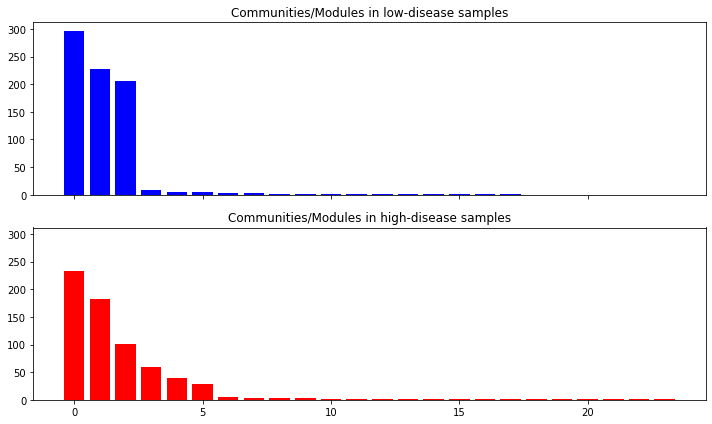

In [8]:
fig, axes = plt.subplots(2, figsize=(10,6), sharey=True, sharex=True)
axes[0].bar(range(0,len(lowAdj_communities)), [ len(i) for i in lowAdj_communities ], color='blue')
axes[0].set_title('Communities/Modules in low-disease samples')
axes[1].bar(range(0,len(highAdj_communities)), [ len(i) for i in highAdj_communities ], color='red')
axes[1].set_title('Communities/Modules in high-disease samples')
plt.tight_layout()

We can look at the networks themselves a little closer to look at the communities, also:

In [9]:
## have to build in community colors into the network node attributes:
gm,gn = [],[]
for i,j in enumerate(lowAdj_communities):
    gn += [i]*len(j)
    gm += list(j)

lowGnum = pd.Series(gn, index=gm)

for i in lowAdj.nodes:
    lowAdj.nodes[i]['comGroup'] = lowGnum[i]


In [58]:
## have to build in community colors into the network node attributes:
gm,gn = [],[]
for i,j in enumerate(lowAdj_communities):
    gn += [i]*len(j)
    gm += list(j)

gnum = pd.Series(gn, index=gm)
## now we need to embed this group membership as an attribute of a node:

for i in lowAdj.nodes:
    lowAdj.nodes[i]['comGroup'] = gnum[i]


In [10]:
def genXKCDColors(nu):
    """we need some colors"""
    Xcolors = random.choices(list(mcolors.XKCD_COLORS.values()), k=nu)
    cmap = mcolors.ListedColormap(Xcolors)
    return(cmap)

In [11]:
colmap = genXKCDColors(len(lowAdj_communities))

node_attrs = {}
for node in lowAdj.nodes(data=False):
    node_color = colmap.colors[lowAdj.nodes[node]['comGroup']]
    node_attrs[node] = node_color

networkx.set_node_attributes(lowAdj, node_attrs, "node_color")

In [12]:
## now use this color attribute with bokeh:

plotLow = figure(title="Low Disease Network",
                x_range=(-2.5,2.5),
                y_range=(-2.5,2.5),
                )

#graph = from_networkx(lowAdj, networkx.fruchterman_reingold_layout, scale=2, center=(0,0))
graphLow = from_networkx(lowAdj, networkx.kamada_kawai_layout, scale=2, center=(0,0))
graphLow.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.4, line_width=2)
graphLow.node_renderer.glyph = Circle(size=15, fill_color="node_color")
plotLow.renderers.append(graphLow)
show(plotLow)


Rinse and repeat for high-disease symptom sample network:

In [13]:
gm,gn = [],[]
for i,j in enumerate(highAdj_communities):
    gn += [i]*len(j)
    gm += list(j)

highGnum = pd.Series(gn, index=gm)

for i in highAdj.nodes:
    highAdj.nodes[i]['comGroup'] = highGnum[i]

colmap = genXKCDColors(len(highAdj_communities))
node_attrs = {}
for node in highAdj.nodes(data=False):
    node_color = colmap.colors[highAdj.nodes[node]['comGroup']]
    node_attrs[node] = node_color

networkx.set_node_attributes(highAdj, node_attrs, "node_color")

plotHigh = figure(title="High Disease Network",
                x_range=(-2.1,2.1),
                y_range=(-2.1,2.1),
                )
graphHigh = from_networkx(highAdj, networkx.kamada_kawai_layout, scale=2, center=(0,0))
graphHigh.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.4, line_width=2)
graphHigh.node_renderer.glyph = Circle(size=15, fill_color="node_color")
plotHigh.renderers.append(graphHigh)
show(plotHigh)

In general, the higher disease network seems like a noisier system. Can we look at the relationships among these modules a little bit? Let's compare them with an NMS, rows are modules/communities:

In [14]:
## make our matrix
aa = pd.get_dummies(lowGnum).T
commsLow = 'low' + aa.index.astype('str')
## add low/high designation
aa.insert(0,"disease",["low"]*aa.shape[0])
aa.index = commsLow
bb = pd.get_dummies(highGnum).T
commsHigh = 'high' + bb.index.astype('str')
bb.insert(0,"disease",["high"]*bb.shape[0])
bb.index = commsHigh
module_comparison = pd.concat([aa,bb]).fillna(0)


Head over to R/vegan for the NMS:

In [3]:
module_comparison = read.csv('module_comparison.csv', row.names=1)
## which modules are the important ones to watch?
aa <- module_comparison[,-1]
nms = metaMDS(aa)

Run 0 stress 9.492327e-05 
Run 1 stress 0.0001946546 
... Procrustes: rmse 0.1484761  max resid 0.5211053 
Run 2 stress 0.0002028432 
... Procrustes: rmse 0.147051  max resid 0.4864909 
Run 3 stress 0.0003977781 
... Procrustes: rmse 0.1506533  max resid 0.5368686 
Run 4 stress 0.0002673579 
... Procrustes: rmse 0.1474571  max resid 0.4810823 
Run 5 stress 0.000185403 
... Procrustes: rmse 0.1359034  max resid 0.4143785 
Run 6 stress 0.0001568517 
... Procrustes: rmse 0.1143751  max resid 0.3811691 
Run 7 stress 0.0001364448 
... Procrustes: rmse 0.1343196  max resid 0.427733 
Run 8 stress 0.0003328185 
... Procrustes: rmse 0.1320225  max resid 0.4332364 
Run 9 stress 0.0004515644 
... Procrustes: rmse 0.1518481  max resid 0.5303944 
Run 10 stress 0.0003582002 
... Procrustes: rmse 0.1495975  max resid 0.4669191 
Run 11 stress 0.0003945775 
... Procrustes: rmse 0.1362605  max resid 0.4486302 
Run 12 stress 0.0001841616 
... Procrustes: rmse 0.1425946  max resid 0.4890678 
Run 13 stress

Warning message in metaMDS(aa):
“stress is (nearly) zero: you may have insufficient data”
Warning message in postMDS(out$points, dis, plot = max(0, plot - 1), ...):
“skipping half-change scaling: too few points below threshold”


Well, that makes sense, we are dealing with some very odd data. By their nature, communities/modules from the same "treatment" (low or high-disease intensity) have to have a BC dissimarility = 1.0. So the poor NMS algorithm is trying to sort a bunch of BC=1 from each other among a bunch of more typical, intermediate-difference comparisons. Some weird things might happen. But let's look at it:

In [4]:
## get sizes and colors right:
bigModules = nms$points[names(rowSums(aa)[rowSums(aa) > 20]),]
## make color from low/high disease 
colrs = vector(length=nrow(module_comparison))
for (i in 1:length(colrs)){
    if (module_comparison[i,1] == "low"){
    colrs[i] <- "blue"
    }
    else {
        if (module_comparison[i,1] == "high"){
        colrs[i] <- "red"
        } } }


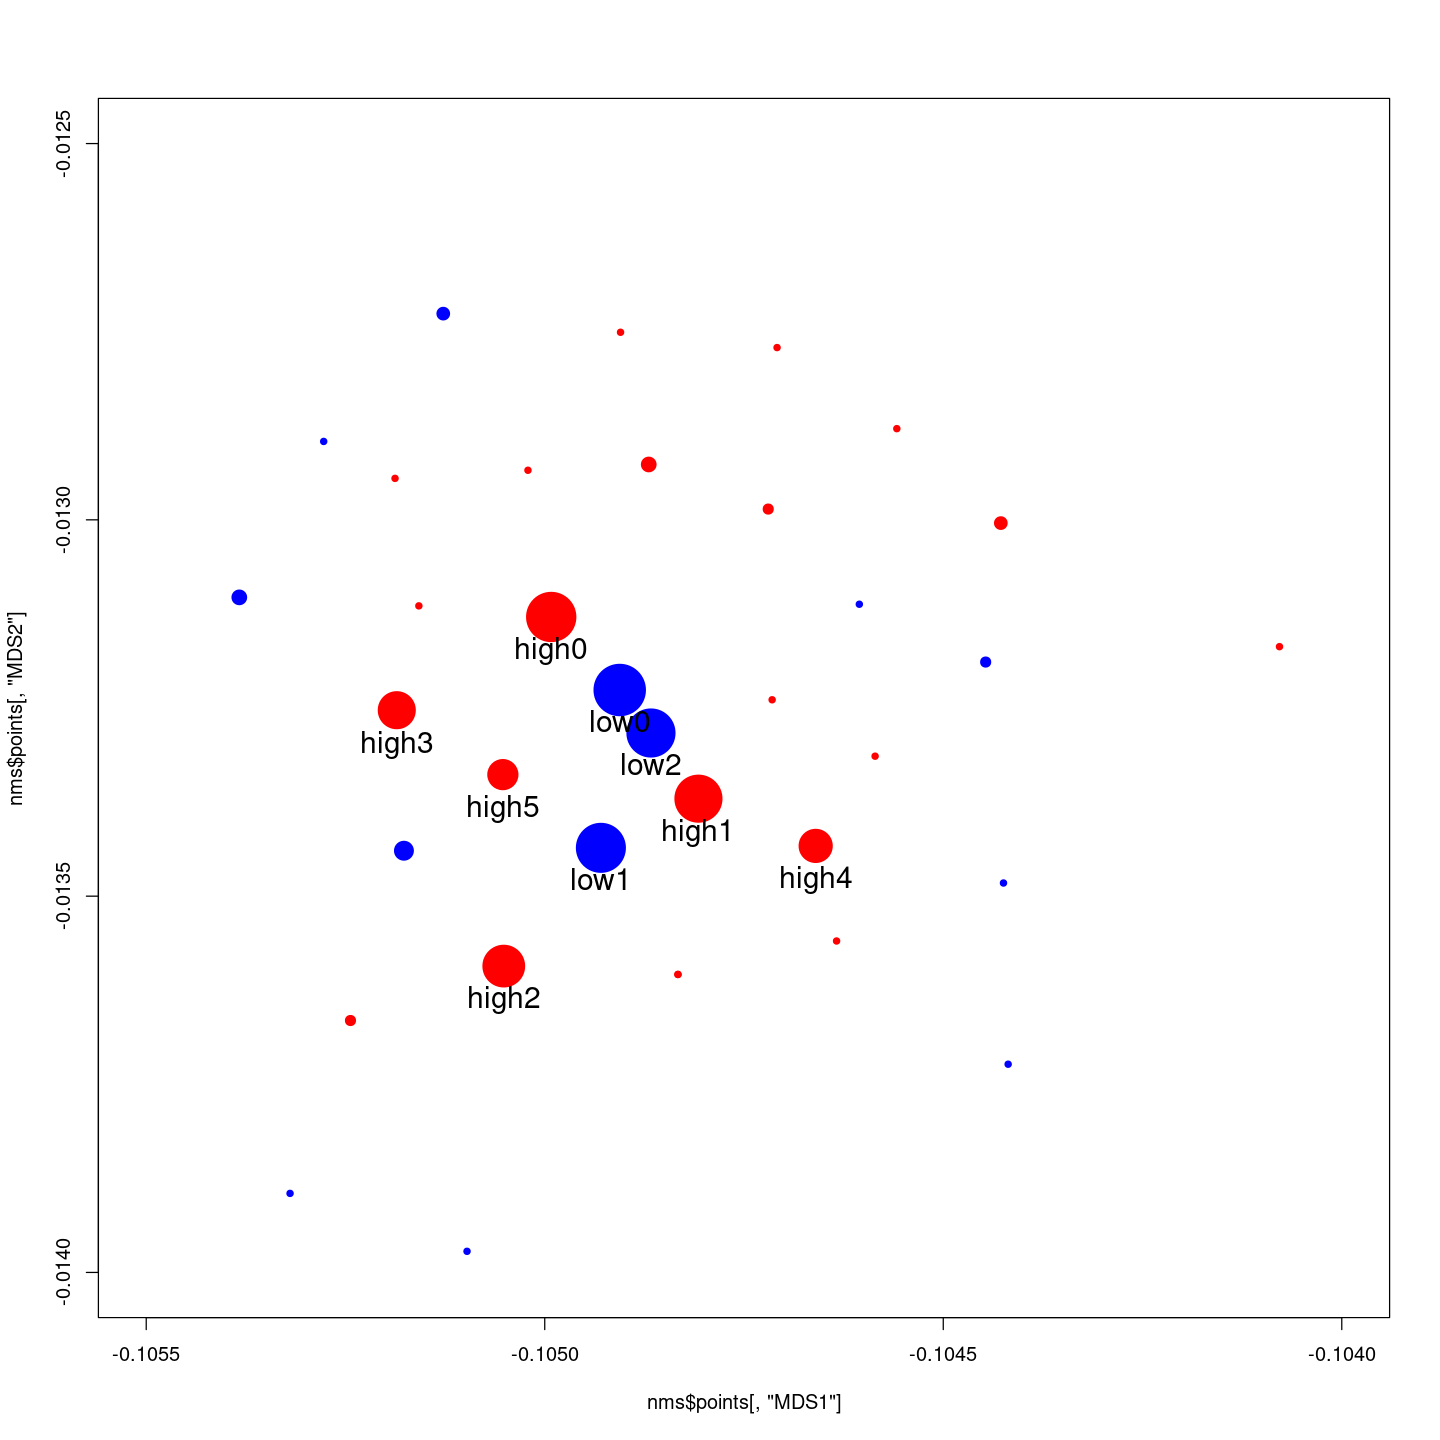

In [11]:
## should use matplotlib or bokeh but oh well
options(repr.plot.width=12, repr.plot.height=12)
plot(nms$points[,'MDS1'],
    nms$points[,'MDS2'],
    col=colrs,
    pch=19,
    cex=log(rowSums(aa)),
    ## zoom in on the important area:
    xlim=c(-0.1055,-0.104),
    ylim=c(-0.0140,-0.0125),
    )
text(bigModules[,'MDS1'],
    bigModules[,'MDS2'],
    row.names(bigModules),
    pos=1,
    offset=1,
    cex=1.5
    )


Low disease intensity modules are blue, high-disease are red. Looks like the big three low-disease modules that exist are being pulled apart. A quick peek at the a venn diagram of the largests modules might show us something. Back to python:

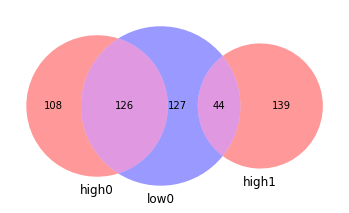

In [15]:
## rerun the python cells at start of section to get communities/modules:
venn3([lowAdj_communities[0],
    highAdj_communities[0],
    highAdj_communities[1]],
    set_labels=("low0",
                "high0",
                "high1"),
    set_colors=("blue","red","red")
                )


Here we've taken the largest community/module from our low-disease state (blue), and looked to see how many of its member OTUS are present in the largest module of the high-disease state ("high0"), and its other nearest neighbor in the above ordination ("high1", red). About half,we see that it is sort of falling apart, or redistributing into other modules in the new, higher-disease state. If we were to look at the other large modules from the high-disease state, we would see they are all "taking a bite" out of this large original, low-disease community of fungi.

[back to top](#top)

<a id="mcc"></a>
##### Mean clustering coefficient

In [34]:
mccLow = np.mean(list(networkx.clustering(lowAdj).values()))
mccHigh = np.mean(list(networkx.clustering(highAdj).values()))
print ("low-disease mean clustering coefficient = " + str(mccLow))
print ("high-disease mean clustering coefficient = " + str(mccHigh))

low-disease mean clustering coefficient = 0.3179890588662486
high-disease mean clustering coefficient = 0.29728532223421955


[back to top](#top)

<a id="cb"></a>
##### Betweenness centrality (CB)

In [35]:
cbLow = np.mean(list(networkx.betweenness_centrality(lowAdj).values()))
cbHigh = np.mean(list(networkx.betweenness_centrality(highAdj).values()))
print("low disease betweenness centrality = " + str(cbLow))
print("Betweenness centrality = " + str(cbHigh))

low disease betweenness centrality = 0.0023433754608529313
Betweenness centrality = 0.0028536647144458915


[back to top](#top)

<a id="cc"></a>
##### Closeness centrality (CC)

In [36]:
ccLow = np.mean(list(networkx.closeness_centrality(lowAdj).values()))
ccHigh = np.mean(list(networkx.closeness_centrality(highAdj).values()))
print("low disease closeness centrality = " + str(ccLow))
print("high disease closeness centrality = " + str(ccHigh))

low disease closeness centrality = 0.33727427009313143
high disease closeness centrality = 0.31036882641522184


Two other indices of interest are nestedness and indicator species. We go back to R for these:

[back to top](#top)

<a id="wnodf"></a>
##### nestedness (WNODF)

To quantify nestedness we use the WNODF index as proposed by [Almeida-Neto and Mário (2011)](https://doi.org/10.1016/j.envsoft.2010.08.003), using the [package MBI](https://cran.r-project.org/package=MBI) in R. So back to the beautiful monster:

In [7]:
lowHiPA <- read.csv('lowHiDiseaseTablePA.csv')
lowPA <- lowHiPA[lowHiPA$lowDisease == 1,4:ncol(lowHiPA)]
highPA <- lowHiPA[lowHiPA$highDisease == 1,4:ncol(lowHiPA)]
lowPawnodf = wnodf(lowPA)
highPawnodf = wnodf(highPA)

print(paste("high disease nestedness (WNODF) =",as.character(highPawnodf$row)))
print(paste("low disease nestedness (WNODF) =",as.character(lowPawnodf$row)))


[1] "high disease nestedness (WNODF) = 43.0634556480638"
[1] "low disease nestedness (WNODF) = 38.3336545758899"


[back to top](#top)

<a id="ind"></a>
##### indicator species

We can also run a classical indicator species analysis on the various disease classes and see if any indicator OTUs can be nominated. Also in R:

In [8]:
aa <- read.csv('lowHiDiseaseTablePA.csv')
aa <- aa[,4:ncol(aa)]
bb <-read.csv('eevaOTU.csv')$Diseaseclass
diseaseClassIndSpp <- multipatt(aa, bb, func = 'r.g', control=how(nperm=9999))
## using r.g function includes a correction for multiple comparisons,
## so don't go farther with a BH.
#save(diseaseClassIndSpp, file='diseaseClassIndSpp.rda')

In [9]:
summary(diseaseClassIndSpp)


 Multilevel pattern analysis
 ---------------------------

 Association function: r.g
 Significance level (alpha): 0.05

 Total number of species: 1266
 Selected number of species: 74 
 Number of species associated to 1 group: 22 
 Number of species associated to 2 groups: 24 
 Number of species associated to 3 groups: 14 
 Number of species associated to 4 groups: 8 
 Number of species associated to 5 groups: 6 

 List of species associated to each combination: 

 Group 2  #sps.  2 
         stat p.value  
OTU1123 0.357   0.015 *
OTU1202 0.321   0.040 *

 Group 3  #sps.  2 
        stat p.value   
OTU357 0.369  0.0059 **
OTU582 0.317  0.0408 * 

 Group 4  #sps.  5 
         stat p.value  
OTU1238 0.356  0.0168 *
OTU728  0.355  0.0179 *
OTU762  0.349  0.0178 *
OTU417  0.332  0.0268 *
OTU909  0.324  0.0323 *

 Group 5  #sps.  13 
         stat p.value   
OTU659  0.449  0.0023 **
OTU1114 0.413  0.0033 **
OTU727  0.398  0.0037 **
OTU811  0.387  0.0049 **
OTU1012 0.387  0.0045 **
OTU986  

We find indicator species, that's encouraging. Interesting that the zero class has none of its own indicators. Disease class 4 always seems to behave like the earlier stages, which is hard to explain. 

[back to top](#top)